<a href="https://colab.research.google.com/github/willmelville/game_theory_sequencing/blob/main/nash_game_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 36.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pybaseball
import tqdm
from scipy.stats import multivariate_normal as mvnorm 
from cvxopt import matrix, solvers
import warnings 
warnings.filterwarnings('ignore')
solvers.options['show_progress'] = False 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

We still need to load all the data in this notebook even though we're not training a model because we need the standard scaler to run data through the model, and we need the right batter indices.

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the data
raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw21.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw18_19_20.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]
raw19 = raw19[needed_columns]

Mounted at /drive


In [ ]:
#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)
#df19 = organize_data(raw19)


all_data = df22.append(df21, ignore_index = True)
#all_data = all_data.append(df19, ignore_index = True)

In [ ]:
#z score variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

In [ ]:
#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge 
all_data = all_data.merge(batter_indices, on = 'batter')

In [ ]:
features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

In [ ]:
bi = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv')

In [ ]:
testing = bi.merge(batter_indices, how = 'inner', on = 'batter_index')

In [ ]:
testing.shape[0], bi.shape[0]

(1761, 1761)

### Model

In [ ]:
#helper classes 

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size
    #define batter embedding 
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state 
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, hidden):
    #batter index is last column of x 
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)
    
    #run through layers 
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size 
        self.output_size = output_size
        #we need a target embedding 
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features 
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding 
        y = self.target_embedding(y)
        #concatenate onto x 
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size 

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings 
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden 
    return output, hidden 

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) 

In [ ]:
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

<All keys matched successfully>

In [ ]:
#prediction function 
def prediction_func(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    preds = torch.empty((1,9)).to(device)
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))
        preds = torch.cat((preds, yhat), dim = 0)
        if recurrent:
          h0 = h1
        else:
          h0 = model.init_hidden().to(device)

    #return predictions
    return preds[1:,:]

### Nash Game

In [ ]:
#define utility function 
count_runs = pd.DataFrame({'balls_pre_event': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes_pre_event': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

def get_utilities(pitch_df):
  '''
  pitch_df is a pandas dataframe with a column for balls, strikes, and the 
  probabilities of each outcome, named o1, o2, o3, o4, o5, o6, o7, and o8

  Returns the expected utility of a swing and of a take for that pitch.
  The batter's optimal utility for the pitch is the larger of those two values
  '''

  pitch_df['swing_utility'] = -1 
  pitch_df['take_utility'] = -1
  pitch_df['total_utility'] = -1
  for balls in pitch_df.balls.unique():
    for strikes in pitch_df.strikes.unique():
      d = pitch_df.loc[(pitch_df.balls == balls) & (pitch_df.strikes == strikes)]

      #get the corresponding row from count_runs table
      count_pre = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes)]

      #get the value of a called ball 
      val0 = count_pre.val_ball.values[0]

      #get the value of a called or swinging strike 
      val12 = count_pre.val_strike.values[0]

      #value of a foul ball 
      if strikes == 2:
        #no change 
        val3 = 0 
      else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0] 

      #value of ball in play out 
      val4 = count_pre.val_out.values[0]
      #single 
      val5 = count_pre.val_single.values[0]
      #double 
      val6 = count_pre.val_double.values[0]
      #triple 
      val7 = count_pre.val_triple.values[0]
      #hr 
      val8 = count_pre.val_hr.values[0]

      #calculate utilities 
      no_swing = d.o0.values + d.o1.values 
      swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
      take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
      swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
      d.swing_utility = swing_utility 
      d.take_utility = take_utility  
      d.total_utility = take_utility * no_swing + swing_utility * swing
      pitch_df.loc[(pitch_df.strikes == strikes) & (pitch_df.balls == balls), ['swing_utility', 'take_utility', 'total_utility']] = d[['swing_utility', 'take_utility', 'total_utility']].values


  return pitch_df       

In [ ]:
#define the set of pitcher and batters you want to run on 
#Chapman, Anderson, Jansen, Robbie Ray
pitchers = [547973, 623433, 445276, 592662]

#Brosseau, Mookie, Brett Phillips, Taveras
batters = [670712, 605141, 621433, 665750]

#get the batter indices for the batters 
batter_idxs = [batter_indices.loc[batter_indices.batter == i , 'batter_index'].values[0] for i in batters]

In [ ]:
batter_idxs

[400, 70, 547, 301]

In [ ]:
#get pitch usages and remove the ones less than like 5% 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in pitchers:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]
pitch_usages

,pitch_type,N,release_speed,mx,mz,release_spin_rate,pitcher_id
0,FF,0.561071,97.868091,4.223499,17.960040,2365.819085,547973
1,FS,0.123815,88.202252,2.469189,-1.775135,807.860360,547973
2,SI,0.051311,100.445652,12.790435,15.943043,2406.554348,547973
3,SL,0.263804,85.210994,-11.891163,3.062410,2273.718816,547973
5,CU,0.305785,81.070270,2.033514,-0.149189,1862.648649,623433
6,FF,0.685950,92.920482,-5.083373,18.300723,2112.277108,623433
7,FC,0.606227,92.397356,7.936767,16.901148,2622.221299,445276
8,SI,0.247711,93.759704,-5.858262,19.220850,2292.927911,445276
9,SL,0.146062,81.662382,5.387210,-6.202382,2453.213166,445276
11,FF,0.494368,94.277086,7.630205,17.510064,2277.327343,592662


When we originally did the nash game, we chose a pitch and a location and we had a swing and take utility at that location. This time with execution score, the swing and take utility at the location needs to be the expected value of all surrounding swing and take utilities, where we calculate the expected value using the 2-d gaussian with mean equal to the point of interest in the grid and variance equal to the execution score. So then when we solve the game, the optimal location we choose to throw in will take into consideration the ability of the pitcher to hit his target. Thus, I first need the swing and take utility at each point in a big grid, and then in a smaller grid I will take the expected value of neighboring points to get the execution score adjusted utilities. So I start with a bigger grid because a normal dist can continue infiniitely in all directions, but our aiming points aren't going to be severely far outside the strike zone, but our bigger grid needs to be big enough that most data in the normal dist (like 3 standard dists) are within the point of interest. So basically we'll take our original grid of aiming points, and expand it by 3 * std_dev in each direction. 

In [ ]:
#define a function that gets the initial grid of utilities, so the grid that will then get uesd to get the execution adjusted grid
#our model requires a hidden state, balls, strikes, and batter and pitch chars to make a prediction. 
#the hidden state will have to be calculated beforehand and plugged in, along with balls, strikes, and handedness.
#this will allow us to just use the output calculation part of OP to make predictions, which will save us time because we won't have to repeatedly update a hidden state 

def initial_grid(batter_idx, pitcherid, h, bhand, phand, balls, strikes):

  #define the grid. I'm adding 3 feet on either side of my normal grid. A baseball is just about 3 inches in diameter, so I'm going to have each point in the grid be half a baseball, so 1.5, so if my dimensions are 9 feet, 
  #I need 9*12/1.5 points in the grid 
  x,z = np.meshgrid(np.linspace(-4.5,4.5,int(9*12/1.5)), np.linspace(-2,7,int(9*12/1.5)))
  x = x.flatten()
  z = z.flatten()
  grid_size = len(x)
  #define the batter and pitcher handedness vecs 
  pvec = np.ones(grid_size) * phand 
  bvec = np.ones(grid_size) * bhand
  #define a location index, so we know how to organize the columns for location
  location_index = np.arange(grid_size)

  #loop through the pitcher's pitches 
  final_data = pd.DataFrame()
  pitcher_usages = pitch_usages.loc[pitch_usages.pitcher_id == pitcherid]
  for pitch in pitcher_usages.pitch_type.unique():
    pitch_chars = pitcher_usages.loc[pitcher_usages.pitch_type == pitch]

    #pitch chars vectors
    svec = np.ones(grid_size) * pitch_chars.release_speed.values[0]
    mxvec = np.ones(grid_size) * pitch_chars.mx.values[0]
    mzvec = np.ones(grid_size) * pitch_chars.mz.values[0]
    srvec = np.ones(grid_size) * pitch_chars.release_spin_rate.values[0]

    #ball and strike vectors 
    balls_v = np.ones(grid_size) * balls 
    strikes_v = np.ones(grid_size) * strikes

    data = pd.DataFrame({'release_speed': svec, 'plate_x' : x, 'plate_z': z,
                             'mx': mxvec, 'mz': mzvec, 'bat_handR': bvec, 
                             'pit_handR': pvec, 'balls': balls_v, 'strikes': strikes_v, 
                             'release_spin_rate': srvec, 'location_index': location_index,
                         'plate_x_ft': x, 'plate_z_ft': z}) 
    
    data['batter_index'] = batter_idx 
    data['pitcher_id'] = pitcherid
    data['pitch_type'] = pitch 
    final_data = final_data.append(data, ignore_index = True)

  #z score variables as needed 
  final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

  #now we can run the model on final_data, but we need to be able to concatenate on the hidden state 
  #repeate hidden so there is one for every pitch in the data 
  hidden = h.repeat(final_data.shape[0], 1)
  #get the data in a tensor 
  x_data = torch.tensor(final_data[features].values, dtype = torch.float).to(device)
  #run x_data and hidden through the output part of the model 
  preds = nn.functional.softmax(model.input_embedding(x_data, hidden), dim = 1)
  final_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()

  return final_data 


In [ ]:
#now use the initial grid and an execution score by pitch type to get the expected utility of a chosen target 
def execution_score_adjusted_grid(init_grid, execution_score_dict):
  #recall init_grid is batter and pitcher specific, so you don't need to worry about having multiple pitchers in init_grid,
  #thus execution_score_dict is a dictionary mapping the execution score to the pitch types for that pitcher 

  #get the location indices corresponding to the smaller grid 
  li = init_grid.loc[(init_grid.plate_x_ft >= -1.5) & (init_grid.plate_x_ft <= 1.5) & (init_grid.plate_z_ft >= 1) & (init_grid.plate_z_ft <= 4), 'location_index'].unique()
  final_data = pd.DataFrame()
  #loop through pitch types 
  for pitch in list(execution_score_dict.keys()):
    d = init_grid.loc[init_grid.pitch_type == pitch]
    #loop through location indices and get the expected utility of swing and take given the pitcher tried to throw the given pitch to the given location index 
    var = execution_score_dict[pitch] ** 2
    for location in li:
      #get the mean for the normal distribution 
      mean = d.loc[d.location_index == location,['plate_x_ft', 'plate_z_ft']].values[0]
      normal = mvnorm(mean, np.eye(2) * var)

      #get likelihoods of all other pitches. 
      d['probability'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
      #I'm a little confused on this, but these probabilities don't sum to 1, which I think is just because we're sampling the normal distribution in discrete space and pretending 
      #like that's a good representation of the pdf even though the pdf is continuous, so I need to normalize them. 
      d.probability = d.probability / d.probability.sum()

      #now calculate expected swing utility and expected take utility 
      exp_take = (d.probability * d.take_utility).sum()
      exp_swing = (d.probability * d.swing_utility).sum()

      final_data = final_data.append(pd.DataFrame({'pitch_type': pitch, 'location_index': location, 'expected_swing_utility': exp_swing, 'expected_take_utility': exp_take}, index = [0]))

  return final_data

In [ ]:
#function that takes as input an A matrix and then solves for the nash equilibrium, returning the batter and pitcher strategy 
def get_strategies(df, plot = True):
  #dataframe is a dataframe like final_data. Note it should already be subsetted to get the right batter, pitcher, and count.
 #get the right columns 
  A = df[['expected_swing_utility', 'expected_take_utility']].values

  #solve the actual batter problem with cvxopt. Use the dual to get pitcher solution

  c = np.hstack((np.zeros(A.shape[1]), np.array([-1.])))
  c = matrix(c)

  top_row = np.hstack((-1*A, np.array([np.ones(A.shape[0])]).T))
  Is = -1* np.eye(A.shape[1])
  bottom_row = np.hstack((Is, np.array([np.zeros(A.shape[1])]).T))
  Aub = np.vstack((top_row, bottom_row))
  G = matrix(Aub)

  b_ub = np.zeros(Aub.shape[0])
  h = matrix(b_ub)

  Aeq = np.array([np.hstack((np.ones(A.shape[1]), np.array([0])))])
  Aeq = matrix(Aeq)

  #define beq, which is just 1 
  b_eq = np.array([1.])
  b = matrix(b_eq)

  batter_sol = solvers.lp(c, G, h, Aeq, b)
  print('Status: ' + batter_sol['status'])

  #get the solutions
  batter_strategy = np.ravel(batter_sol['x'])[:2]
  batter_optimal = -1*np.ravel(batter_sol['primal objective'])
  pitcher_strategy = np.ravel(batter_sol['z'])[:A.shape[0]]
  df['pitch_decision_probability_cvxopt'] = pitcher_strategy

  if plot:
    #plots 
    plt.plot([i for i in range(A.shape[0])], pitcher_strategy)
    plt.title('PItcher Decision Distribution')
    plt.show()

    pitches = df.pitch_type.unique()
    fig = plt.figure(figsize = (18,4))
    num_pitches = len(pitches)
    for i in range(num_pitches):
      ax = plt.subplot(1,num_pitches, i+1)
      d = df.loc[df.pitch_type == pitches[i]]
      #zero out values that are really small
      d.loc[d.pitch_decision_probability_cvxopt < 1e-4, 'pitch_decision_probability_cvxopt'] = 0
      d = d.loc[d.pitch_decision_probability_cvxopt > 0]
      c = ax.scatter(-1*d.plate_x_ft.values, d.plate_z_ft.values, c = d.pitch_decision_probability_cvxopt.values, cmap = 'coolwarm', vmin = 0, vmax = 0.99)
      fig.colorbar(c, ax=ax)
      #plot the standard strize zone as well
      ax.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
      ax.set_xlabel("Horizontal Location (Pitcher's Perspective)")
      ax.set_ylabel('Vertical Location')
      ax.set_xlim(-1.6,1.6)
      ax.set_ylim(0.9,4.1)
      ax.set_title(pitches[i])

    plt.tight_layout()
    plt.show()
  return df, batter_strategy, batter_optimal

### **Brosseau HR off of Chapman**

https://www.youtube.com/watch?v=XctGlhYnQb4

In [ ]:
#get the at bat from pybaseball, the game was on october 9 2020, and it was the only
#at bat between Chapman and Brosseau, so it should be easy to find in the data 
alds_game_5 = pybaseball.statcast(start_dt = '2020-10-09', end_dt = '2020-10-09')

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


In [ ]:
alds_game_5 = alds_game_5[needed_columns]
alds_game_5 = organize_data(alds_game_5)

In [ ]:
bross_pa = alds_game_5.loc[(alds_game_5.batter == batters[0]) & (alds_game_5.pitcher == pitchers[0])]
bross_pa['batter_index'] = batter_idxs[0]

#run the model on the brosseau pa. Store the hidden state after the second to last pitch, so we can suggest what Chapman should have actually thrown.
bross_pa = bross_pa[::-1]
bross_pa['plate_x_ft'] = bross_pa.plate_x 
bross_pa['plate_z_ft'] = bross_pa.plate_z 
bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.transform(bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(bross_pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(bross_pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(bross_pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == bross_pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() ##### bug fix, to avoid a mutability issue, we need to clone h0

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
bross_pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
bross_pa = get_utilities(bross_pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
bross_pa.tail(1)[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
172,"Chapman, Aroldis",670712,FF,3,2,-0.690644,-0.165659,-0.54,2.12,8,0.002091,0.084918,0.111242,0.476575,0.215287,0.069385,0.022547,0.001767,0.016188,-0.048694,-0.335929


In [ ]:
#we calculated the hidden state after the 9th pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Chapman's pitches 
#given the prior sequence
igrid = initial_grid(batter_idxs[0], pitchers[0], h, bhand = 1., phand = 0., balls = 3, strikes = 2)
#calculate the utilities for igrid 
igrid = get_utilities(igrid)

In [ ]:
#get the execution grid with Chapman's execution scores
exe_grid = execution_score_adjusted_grid(igrid, {'FF': 0.753, 'FS': 0.921, 'SI': 0.719, 'SL': 0.657})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

Status: optimal


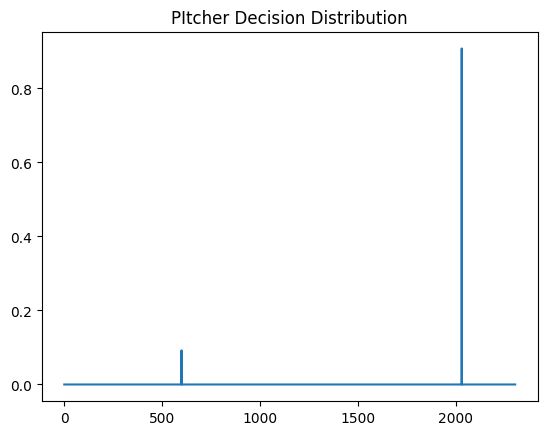

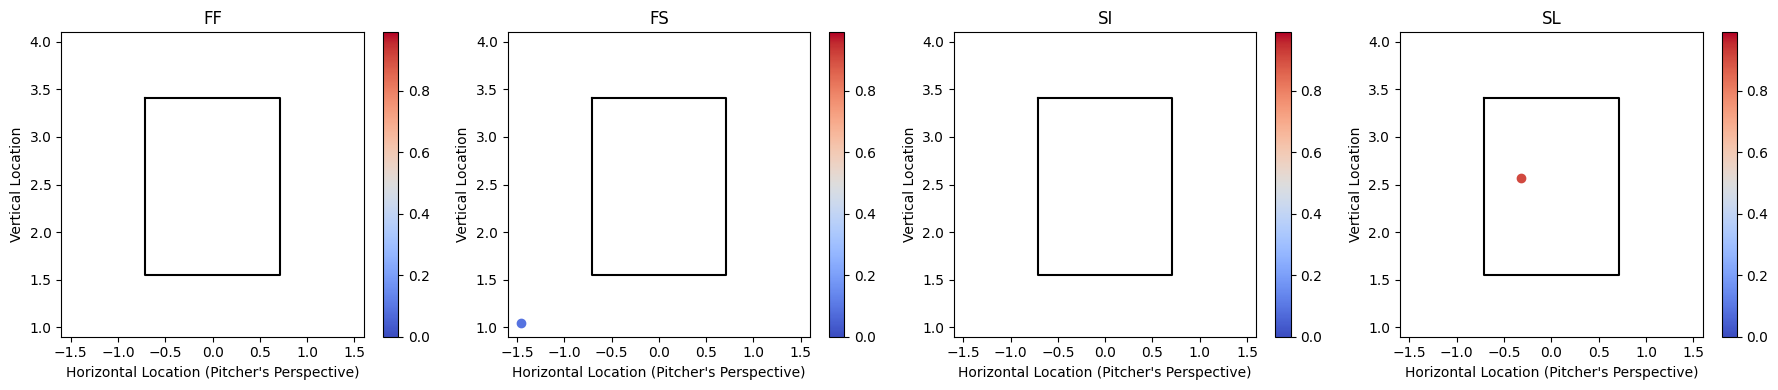

In [ ]:
#now the A matrix of our game is given by the expected_swing_utility and expected_take_utility of the previous dataframe
game_df, batter_strategy, utility = get_strategies(final_data)

In [ ]:
game_df.loc[game_df.pitch_decision_probability_cvxopt > 0.001]

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,total_utility,expected_swing_utility,expected_take_utility,pitch_decision_probability_cvxopt
599,-0.111033,1.676628,-1.267857,0.362225,-1.055385,1.0,0.0,3.0,2.0,-4.286220,1775,1.457746,1.042254,400,547973,FS,0.745926,0.000050,0.212811,0.026718,0.011239,0.003061,0.000172,0.000006,0.000017,-0.303725,0.275958,0.128704,-0.280168,0.217921,0.092185
2030,-0.601416,0.324760,0.287780,-1.002816,-0.515481,1.0,0.0,3.0,2.0,0.098252,2630,0.316901,2.563380,400,547973,SL,0.000245,0.097608,0.149191,0.366963,0.256641,0.068842,0.029137,0.002521,0.028853,-0.055309,-0.349431,-0.084089,-0.104929,-0.155508,0.907815


In [ ]:
batter_strategy, utility

(array([0.68060993, 0.31939007]), array([-0.12108326]))

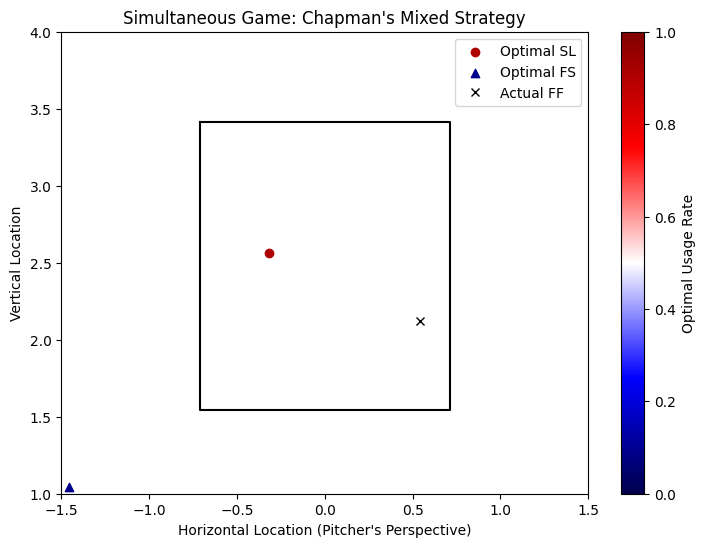

In [ ]:
#better plots for paper 
plt.figure(figsize = (8.5,6))
d = game_df.loc[(game_df.pitch_decision_probability_cvxopt > 0.00001)]
fc = d.loc[d.pitch_type == 'FS']
sl = d.loc[d.pitch_type == 'SL']
plt.scatter(-1*sl.plate_x_ft.values[0], sl.plate_z_ft.values[0], marker = 'o', label = 'Optimal SL', c = sl.pitch_decision_probability_cvxopt.values[0], cmap = 'seismic', vmin = 0, vmax = 1)
c = plt.scatter(-1*fc.plate_x_ft.values[0], fc.plate_z_ft.values[0], marker = '^', label = 'Optimal FS', c = fc.pitch_decision_probability_cvxopt.values[0], cmap = 'seismic', vmin = 0, vmax = 1)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Chapman threw 
plt.plot([0.54], [2.12], 'kx', label = "Actual FF")
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-1.5,1.5)
plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("Simultaneous Game: Chapman's Mixed Strategy")
plt.show()




### **Anderson vs Mookie**

In [ ]:
#get the at bat from pybaseball, the game was on october 27 2020, and it was the only
#at bat between Betts and Anderson
ws_game_6 = pybaseball.statcast(start_dt = '2020-10-27', end_dt = '2020-10-27')

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [ ]:
ws_game_6 = ws_game_6[needed_columns]
ws_game_6 = organize_data(ws_game_6)

In [ ]:
betts_pa = ws_game_6.loc[(ws_game_6.batter == batters[1]) & (ws_game_6.pitcher == pitchers[1])]
betts_pa['batter_index'] = batter_idxs[0]

#run the model on the betts pa. Store the hidden state after the second to last pitch, so we can suggest what Anderson should have actually thrown.
betts_pa = betts_pa[::-1]
betts_pa['plate_x_ft'] = betts_pa.plate_x 
betts_pa['plate_z_ft'] = betts_pa.plate_z 
betts_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.transform(betts_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(betts_pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(betts_pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(betts_pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == betts_pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone()   #### bug fix, we need to clone h0 here to avoid a mutability issue

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
betts_pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
betts_pa = get_utilities(betts_pa)

In [ ]:
betts_pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
250,"Anderson, Nick",605141,FF,0,0,1.442304,0.928616,1.26,3.19,0,0.963052,0.003360,0.013706,0.014435,0.003946,0.001245,0.000199,0.000008,0.000049,-0.044683,0.033732
244,"Anderson, Nick",605141,FF,1,0,1.596351,0.539995,1.39,2.81,0,0.945325,0.001322,0.024427,0.021488,0.005537,0.001574,0.000254,0.000011,0.000061,-0.057607,0.062842
230,"Anderson, Nick",605141,FF,2,0,0.375830,0.539995,0.36,2.81,6,0.000334,0.190749,0.184170,0.393008,0.151570,0.040331,0.017686,0.001666,0.020486,-0.046255,-0.061699


In [ ]:
#we calculated the hidden state after the 2nd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Anderson's pitches 
#given the prior sequence
igrid = initial_grid(batter_idxs[1], pitchers[1], h, bhand = 1., phand = 1., balls = 2, strikes = 0)
#calculate the utilities for igrid 
igrid = get_utilities(igrid)

In [ ]:
#get the execution grid with Anderson's execution scores
exe_grid = execution_score_adjusted_grid(igrid, {'CU': 0.604, 'FF': 0.521})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

Status: optimal


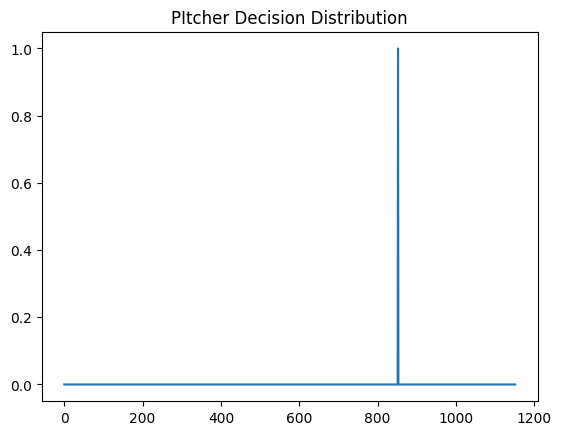

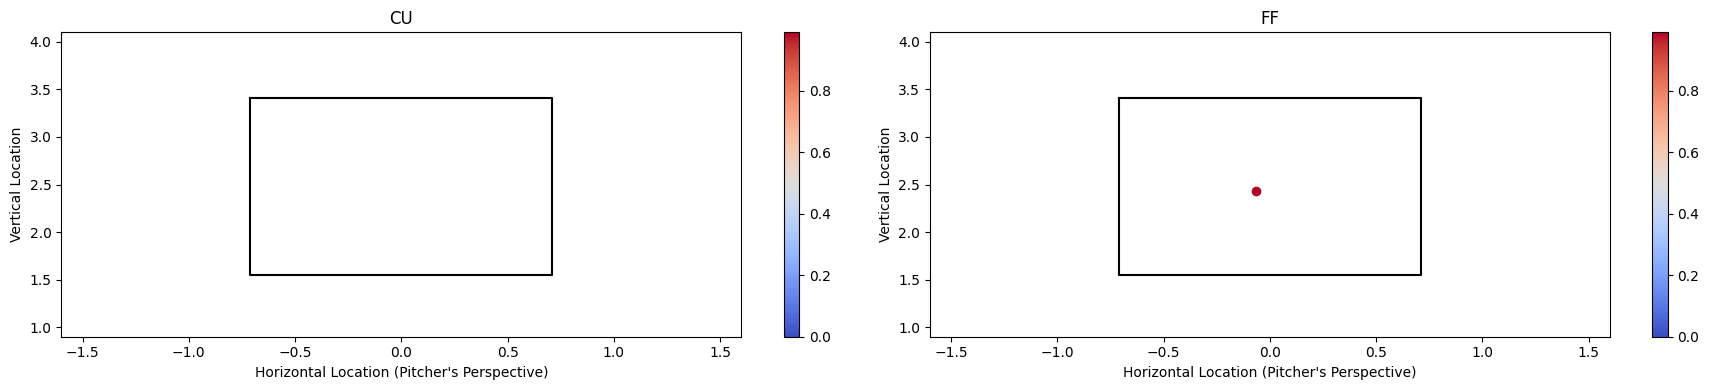

In [ ]:
#now the A matrix of our game is given by the expected_swing_utility and expected_take_utility of the previous dataframe
game_df, batter_strategy, utility = get_strategies(final_data)

In [ ]:
game_df.loc[game_df.pitch_decision_probability_cvxopt > 0.001]

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,total_utility,expected_swing_utility,expected_take_utility,pitch_decision_probability_cvxopt
852,0.662468,0.024344,0.158143,-0.355693,1.185223,1.0,1.0,2.0,0.0,-0.38463,2556,0.06338,2.43662,70,623433,FF,0.000168,0.244226,0.111845,0.358153,0.182527,0.049035,0.02353,0.002166,0.02835,-0.032289,-0.061882,-0.039522,-0.048044,-0.036892,1.0


In [ ]:
#this being true shows that after factoring in exectuion score, no matter what pitch and location Anderson tries to throw, Mooke is better off taking it than swinging at it, which is why we have the pure strategy
np.all(game_df.expected_swing_utility.values < game_df.expected_take_utility.values)

True

In [ ]:
batter_strategy, utility

(array([3.52674697e-09, 9.99999996e-01]), array([-0.03689185]))

### **Jansen and Phillips**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-24', end_dt = '2020-10-24')

game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


In [ ]:
pa = game.loc[(game.batter == batters[2]) & (game.pitcher == pitchers[2])]
pa['batter_index'] = batter_idxs[2]

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() #### bug fix, we need to clone h0 here

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

In [ ]:
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility', 'total_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,total_utility
137,"Jansen, Kenley",621433,FC,0,0,1.146061,-0.073618,1.01,2.21,0,0.359006,0.031942,0.126646,0.338238,0.106224,0.027180,0.007599,0.000437,0.002729,-0.044253,0.027709,-0.016120
132,"Jansen, Kenley",621433,FC,1,0,0.980166,0.785439,0.87,3.05,1,0.338521,0.105583,0.069858,0.310959,0.130165,0.030707,0.009224,0.000622,0.004362,-0.060000,0.036135,-0.017306
130,"Jansen, Kenley",621433,SI,1,1,-1.046135,-0.462239,-0.84,1.83,1,0.414153,0.459284,0.022835,0.056786,0.031509,0.010899,0.003123,0.000260,0.001151,-0.031176,-0.011523,-0.014010
119,"Jansen, Kenley",621433,FC,1,2,0.494327,0.130920,0.46,2.41,5,0.000996,0.026303,0.060885,0.420487,0.337110,0.101409,0.029200,0.002181,0.021429,0.037448,-0.196806,0.031053


In [ ]:
#we calculated the hidden state after the 3rd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Jansen's pitches 
#given the prior sequence
igrid = initial_grid(batter_idxs[2], pitchers[2], h, bhand = 0., phand = 1., balls = 1, strikes = 2)
#calculate the utilities for igrid 
igrid = get_utilities(igrid)

In [ ]:
#get the execution grid with JAnsen's execution scores
exe_grid = execution_score_adjusted_grid(igrid, {'FC': 0.51, 'SI':0.61, 'SL': 0.636})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

Status: optimal


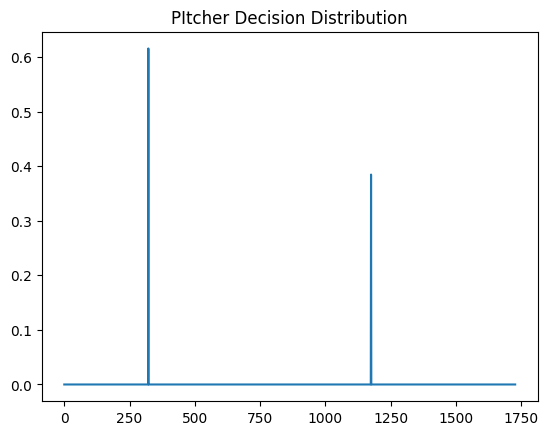

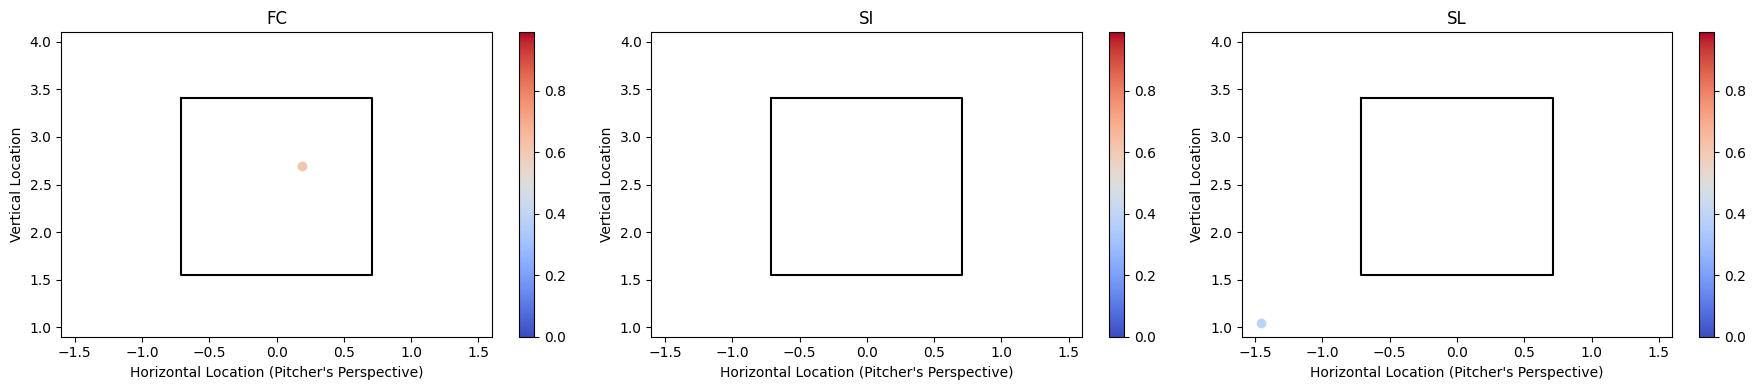

In [ ]:
#now the A matrix of our game is given by the expected_swing_utility and expected_take_utility of the previous dataframe
game_df, batter_strategy, utility = get_strategies(final_data)

In [ ]:
game_df.loc[game_df.pitch_decision_probability_cvxopt > 0.00001]

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,total_utility,expected_swing_utility,expected_take_utility,pitch_decision_probability_cvxopt
322,0.576707,-0.276071,0.417416,0.881953,1.029020,0.0,1.0,1.0,2.0,1.140644,2698,-0.190141,2.690141,547,445276,FC,0.000728,0.124187,0.154736,0.449483,0.180159,0.049398,0.020117,0.001739,0.019453,0.009188,-0.204531,-0.017509,-0.008764,-0.133131,0.615496
1175,-1.183171,1.676628,-1.267857,0.639602,-1.549497,0.0,1.0,1.0,2.0,0.635130,1775,1.457746,1.042254,547,445276,SL,0.878600,0.000003,0.108438,0.010849,0.001515,0.000531,0.000058,0.000001,0.000005,-0.183570,0.045999,0.018130,-0.159909,0.039172,0.384504


In [ ]:
batter_strategy, utility

(array([0.53270739, 0.46729261]), array([-0.06687998]))

In [ ]:
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
137,"Jansen, Kenley",621433,FC,0,0,1.146061,-0.073618,1.01,2.21,0,0.359006,0.031942,0.126646,0.338238,0.106224,0.027180,0.007599,0.000437,0.002729,-0.044253,0.027709
132,"Jansen, Kenley",621433,FC,1,0,0.980166,0.785439,0.87,3.05,1,0.338521,0.105583,0.069858,0.310959,0.130165,0.030707,0.009224,0.000622,0.004362,-0.060000,0.036135
130,"Jansen, Kenley",621433,SI,1,1,-1.046135,-0.462239,-0.84,1.83,1,0.414153,0.459284,0.022835,0.056786,0.031509,0.010899,0.003123,0.000260,0.001151,-0.031176,-0.011523
119,"Jansen, Kenley",621433,FC,1,2,0.494327,0.130920,0.46,2.41,5,0.000996,0.026303,0.060885,0.420487,0.337110,0.101409,0.029200,0.002181,0.021429,0.037448,-0.196806


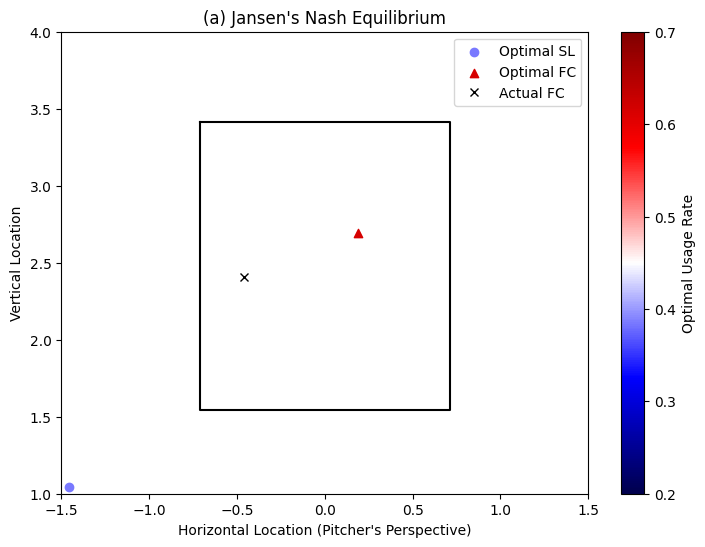

In [ ]:
#better plots for paper 
plt.figure(figsize = (8.5,6))
d = game_df.loc[(game_df.pitch_decision_probability_cvxopt > 0.00001)]
fc = d.loc[d.pitch_type == 'FC']
sl = d.loc[d.pitch_type == 'SL']
plt.scatter(-1*sl.plate_x_ft.values[0], sl.plate_z_ft.values[0], marker = 'o', label = 'Optimal SL', c = sl.pitch_decision_probability_cvxopt.values[0], cmap = 'seismic', vmin = 0.2, vmax = 0.7)
c = plt.scatter(-1*fc.plate_x_ft.values[0], fc.plate_z_ft.values[0], marker = '^', label = 'Optimal FC', c = fc.pitch_decision_probability_cvxopt.values[0], cmap = 'seismic', vmin = 0.2, vmax = 0.7)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Jansen threw 
plt.plot([-0.46], [2.41], 'kx', label = "Actual FC")
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-1.5,1.5)
plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("(a) Jansen's Nash Equilibrium")
plt.show()


